In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.svm import SVC
from sklearn.utils import class_weight
from skimage.feature import texture
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from joblib import dump, load
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

## Feature extraction

In [ ]:
def Color_features(image_mul_mask):
    Color_Mean_Std = []
    for i in range(3):
        canal = image_mul_mask[:,:,i]
        max_value = canal.max()
        min_value = canal[canal>0].min()
        (means, stds) = cv2.meanStdDev(canal[canal>0])
        Color_Mean_Std.append([max_value,min_value,float(means),float(stds)])
    Color_Mean_Std = np.asarray(Color_Mean_Std).flatten()  
    return Color_Mean_Std

def Hist_features(image_mul_mask):
    gray_image_mul_mask = cv2.cvtColor(image_mul_mask, cv2.COLOR_BGR2GRAY)
    Hist_features = []
    hist_0 = cv2.calcHist([image_mul_mask],[0],None,[8],[1,256])
    hist_1 = cv2.calcHist([image_mul_mask],[1],None,[8],[1,256])
    hist_2 = cv2.calcHist([image_mul_mask],[2],None,[8],[1,256])
    hist_gray = cv2.calcHist([gray_image_mul_mask],[0],None,[8],[1,256])
    Hist_features.append(hist_0)
    Hist_features.append(hist_1)
    Hist_features.append(hist_2)
    Hist_features.append(hist_gray)
    Hist_features = np.asarray(Hist_features).flatten()    
    return Hist_features

def Contour_features(image_mul_mask):
    gray_image_mul_mask = cv2.cvtColor(image_mul_mask, cv2.COLOR_BGR2GRAY)
    contour_features = []

    ret,thresh = cv2.threshold(gray_image_mul_mask,0.5,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    max_cnt = max(contours, key=cv2.contourArea)


    ellipse = cv2.fitEllipse(max_cnt)
    ellipse_pnts = cv2.ellipse2Poly( (int(ellipse[0][0]),int(ellipse[0][1]) ) ,( int(ellipse[1][0]),int(ellipse[1][1]) ),int(ellipse[2]),0,360,1)
    comp_ellipse = cv2.matchShapes(max_cnt,ellipse_pnts,1,0.0)
    contour_features.append(comp_ellipse)

    (x,y),(MA,ma),angle = cv2.fitEllipse(max_cnt) #MA,ma 分别为长轴短轴长度
    contour_features.append(float(MA)/ma)

    area=cv2.contourArea(max_cnt)
    x,y,w,h=cv2.boundingRect(max_cnt)
    rect_area=w*h
    extent=float(area)/rect_area
    contour_features.append(extent)

    hull=cv2.convexHull(max_cnt)
    hull_area=cv2.contourArea(hull)
    solidity=float(area)/hull_area
    contour_features.append(solidity)

    perimeter = cv2.arcLength(max_cnt,True)
    contour_features.append(perimeter**2/area)
    croped_image = gray_image_mul_mask[int(y):int(y+h),int(x):int(x+w)]
    
    contour_features = np.asarray(contour_features).flatten()  
    return contour_features,croped_image

def Texture_features(croped_image):
    texture_feature = []
    GLCM = texture.greycomatrix(croped_image, [1], [0, np.pi/4,np.pi/2,np.pi*3/4])
    prop_attributes= ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in prop_attributes:
        texture_feature.append(texture.greycoprops(GLCM,prop).flatten())
    texture_feature = np.asarray(texture_feature).flatten()
    return texture_feature
    


def read_data(path='data/train.csv'):  
    data = pd.read_csv(path)
    X_data = data['ImageId']
    y_data = data['Malignant']
    X_id = X_data.values
    Y = y_data.values

    feature_size = 73
    data_size = X_id.shape[0]

    # read data
    X_features = np.zeros((data_size,feature_size))

    for i in range(data_size):
        name = X_id[i]
        filename = 'data/im/{}.jpg'.format(name)
        image = cv2.imread(filename)
        filename_Segmentation = 'data/im/{}_segmentation.jpg'.format(name)
        image_Segmentation = cv2.imread(filename_Segmentation) # Value 0 or 255
        image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint8
        image_Segmentation_expand = image_Segmentation_boolean#np.expand_dims(image_Segmentation_boolean, axis=2)
        image_mul_mask = (image_Segmentation_expand*image) 
       
        #feature extraction
        features = (Color_features(image_mul_mask))
        features = np.hstack((features, Hist_features(image_mul_mask)))
        Contour,croped_image = Contour_features(image_mul_mask)
        features = np.hstack((features, Contour))
        features = np.hstack((features, Texture_features(croped_image)))
        X_features[i]=np.nan_to_num(features)
    return X_features.astype('float32'),Y[:data_size]

## First time input image feature extraction and save to disk

In [ ]:
''' Process and store train image features'''
# X,Y = read_data()
# scaler = StandardScaler()
# scaler.fit(X)
# X_scale=scaler.transform(X)
# np.save('X_train_feature.npy', X_scale) # save
# np.save('Y_train.npy', Y) # save

''' Process and store test image features'''
#X,_ = read_data("data/test.csv")
# scaler = StandardScaler()
# scaler.fit(X)
# X_scale=scaler.transform(X)
# np.save('X_test_feature.npy', X_scale) # save

## Loaded stored features

In [2]:
''' Load train image features'''
X_scale = np.load('X_train_feature.npy') # load
Y = np.load('Y_train.npy') # load

X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.15, random_state=42)

## Forward feature selection 

In [ ]:
# '''Implement forward feature selection '''

# X_new = SelectPercentile(f_classif, percentile=10).fit_transform(X_scale, Y)
# print(X_new.shape)
# X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.15, random_state=42)
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## PCA

In [ ]:
# '''Implement PCA '''

# pca = PCA(n_components=0.95)
# pca.fit(X_scale)
# X_pca = pca.transform(X_scale)
# X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.15, random_state=42)
# print("feature dimention after PCA:", X_test.shape[1])

## SVM classifier

In [ ]:
param_grid = {"C": [1e-1,1,2,3,4,5,6],
              "gamma":['scale','auto'],
              "kernel": ['linear','rbf','sigmoid'],
              "class_weight": ['balanced'],
              "shrinking": [True,False],
              }

clf = SVC()
gsSVC = GridSearchCV(clf,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsSVC.fit(X_train,y_train)
SVC_best = gsSVC.best_estimator_
scores_SVC = gsSVC.score(X_test,y_test)
print("Best SVM classfier validation score:",scores_SVC)

In [ ]:
gsSVC.best_params_

## K Nearest Neighbors

In [ ]:
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
param_grid = {
              "n_neighbors": [8,9,10],
              "weights" : ['uniform','distance'],
              "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "leaf_size" : [2,3,4],
              "p":[1,2,3],
              "n_jobs":[-1]
              }

KNN = KNeighborsClassifier()
gsKNN = GridSearchCV(KNN,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsKNN.fit(X_train,y_train)
KNN_best = gsKNN.best_estimator_
scores_KNN = gsKNN.score(X_test,y_test)
print("Best KNN Classifier validation score:",scores_KNN)

In [ ]:
gsKNN.best_params_

## Logistic regression classifier

In [ ]:
param_grid = {
              "C": [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,3,4],
              "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              "class_weight": ['balanced'],
              }

LR = LogisticRegression()
gsLR = GridSearchCV(LR,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsLR.fit(X_train,y_train)
LR_best = gsLR.best_estimator_
scores_LR = gsLR.score(X_test,y_test)
print("Best LR Classifier validation score:",scores_LR)

In [ ]:
gsLR.best_params_

## Random forest and Extra tree classifier

In [ ]:
param_grid = {
              "max_depth": [None,2,3,5,15,25],
              "max_features": ['auto','sqrt','log2'],
              "min_samples_split": [2,3, 5],
              "min_samples_leaf": [1,3, 5],
              "n_estimators" :[100,300,500],
              "criterion": ["gini","entropy"],
              "class_weight": ['balanced']}

ETC = ExtraTreesClassifier()
gsETR = GridSearchCV(ETC,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsETR.fit(X_train,y_train)
ETR_best = gsETR.best_estimator_
scores_ETC = gsETR.score(X_test,y_test)
print("Best ExtraTreesClassifier validation score:",scores_ETC)

RFC = RandomForestClassifier()
gsRFC = GridSearchCV(RFC,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_
scores_RFC = gsRFC.score(X_test,y_test)


print("Best RandomForestClassifier validation score:",scores_RFC)

In [ ]:
gsETR.best_params_

In [ ]:
gsRFC.best_params_

## AdaBoost

In [ ]:
param_grid = {
              'algorithm' : ['SAMME', "SAMME.R"],
              "n_estimators" :[100,300,600]}
Basic_clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,max_features='sqrt',min_samples_leaf=1,min_samples_split=3,class_weight='balanced')
AdaBoost = AdaBoostClassifier(Basic_clf)
gsAdaBoost = GridSearchCV(AdaBoost,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsAdaBoost.fit(X_train,y_train)
AdaBoost_best = gsAdaBoost.best_estimator_
scores_AdaBoost = gsAdaBoost.score(X_test,y_test)

print("Best AdaBoostClassifier validation score:",scores_AdaBoost)

In [ ]:
gsAdaBoost.best_params_

## Xgboost

In [ ]:
param_grid = {
              "booster": ['gbtree'],
              "objective": ['binary:logistic','binary:hinge'],
               'max_depth': [3,4,5], # 5 is good but takes too long in kaggle env
               'subsample': [0.5,0.7,0.9],
                'colsample_bytree': [0.6,0.7,0.8],
                'n_estimators': [500,1000],
                'reg_alpha': [0.1, 1, 10,100],
                'min_child_weight': [1,2,3],
                'gamma':[0,0.1],
                'scale_pos_weight':[1]
}

XGB = xgb.XGBClassifier()
gsXGB = GridSearchCV(XGB,param_grid = param_grid, cv=5, n_jobs= -1, verbose = 1)
gsXGB.fit(X_train,y_train)
XGB_best = gsXGB.best_estimator_
scores_XGB = gsXGB.score(X_test,y_test)
print("Best XGBClassifier validation score:",scores_XGB)

In [ ]:
gsXGB.best_params_

## Stacking

In [ ]:
scores_SVC= SVC_best.score(X_test,y_test)
scores_KNN= KNN_best.score(X_test,y_test)
scores_LR= LR_best.score(X_test,y_test)
scores_ETC= ETR_best.score(X_test,y_test)
scores_RFC= RFC_best.score(X_test,y_test)
scores_AdaBoost= AdaBoost_best.score(X_test,y_test) 
scores_XGB= XGB_best.score(X_test,y_test)

In [ ]:
SVC_best.probability = True
weights=[scores_SVC, scores_LR, scores_KNN,
         scores_ETC, scores_RFC,scores_AdaBoost,scores_XGB
        ]
weights /= min(weights)
weights -= 1
weights *= 100
ensemble = VotingClassifier(estimators=[('SVC', SVC_best), ('LR', LR_best),('KNN', KNN_best),
                                        ('ETC', ETR_best),('RFC',RFC_best)
                                        ,('AdaBoost',AdaBoost_best),('XGB',XGB_best)
                                   ], voting='hard', weights=weights)
ensemble = ensemble.fit(X_train, y_train)
scores_ensemble = ensemble.score(X_test,y_test)
print("ensembled Classifier validation score:",scores_ensemble)

## Save model

In [ ]:
# dump(SVC_best, 'data/Model/SVC_FS.joblib') 
# dump(LR_best, 'data/Model/LR_FS.joblib') 
# dump(KNN_best, 'data/Model/KNN_FS.joblib') 
# #dump(ETR_best, 'data/Model/ETC_PCA.joblib') 
# #dump(RFC_best, 'data/Model/RFC_orinigal.joblib') 
# dump(AdaBoost_best, 'data/Model/AdaBoost_FS.joblib') 
# dump(XGB_best, 'data/Model/XGB_FS.joblib')
# dump(ensemble, 'data/Model/ensemble_FS.joblib')

## Analyze results

In [6]:
SVC_best= load('data/Model/SVC_orinigal.joblib') 
LR_best= load('data/Model/LR_orinigal.joblib') 
KNN_best= load('data/Model/KNN_orinigal.joblib') 
ETR_best= load('data/Model/ETC_orinigal.joblib') 
RFC_best= load('data/Model/RFC_orinigal.joblib') 
AdaBoost_best= load('data/Model/AdaBoost_orinigal.joblib') 
XGB_best= load('data/Model/XGB_orinigal.joblib')
ensemble= load('data/Model/ensemble_orinigal.joblib')
SVC_PCA= load('data/Model/SVC_PCA.joblib') 
LR_PCA= load('data/Model/LR_PCA.joblib') 
KNN_PCA= load('data/Model/KNN_PCA.joblib') 
ETR_PCA= load('data/Model/ETC_PCA.joblib') 
RFC_PCA= load('data/Model/RFC_PCA.joblib') 
AdaBoost_PCA= load('data/Model/AdaBoost_PCA.joblib') 
XGB_PCA= load('data/Model/XGB_PCA.joblib')
ensemble_PCA= load('data/Model/ensemble_PCA.joblib')
SVC_FS= load('data/Model/SVC_FS.joblib') 
LR_FS= load('data/Model/LR_FS.joblib') 
KNN_FS= load('data/Model/KNN_FS.joblib') 
ETR_FS= load('data/Model/ETC_FS.joblib') 
RFC_FS= load('data/Model/RFC_FS.joblib') 
AdaBoost_FS= load('data/Model/AdaBoost_FS.joblib') 
XGB_FS= load('data/Model/XGB_FS.joblib')
ensemble_FS= load('data/Model/ensemble_FS.joblib')

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Classifier:  SVC
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        61
           1       0.77      0.61      0.68        44

   micro avg       0.76      0.76      0.76       105
   macro avg       0.76      0.74      0.75       105
weighted avg       0.76      0.76      0.76       105

Normalized confusion matrix
[[0.86885246 0.13114754]
 [0.38636364 0.61363636]]


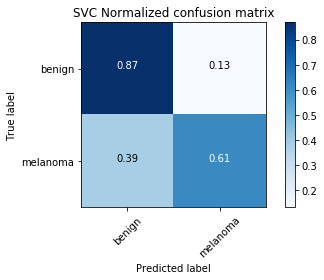

Classifier:  LR
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        61
           1       0.62      0.59      0.60        44

   micro avg       0.68      0.68      0.68       105
   macro avg       0.67      0.66      0.67       105
weighted avg       0.67      0.68      0.68       105

Normalized confusion matrix
[[0.73770492 0.26229508]
 [0.40909091 0.59090909]]


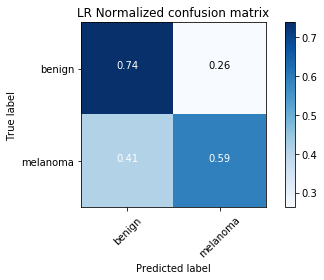

Classifier:  KNN
              precision    recall  f1-score   support

           0       0.69      0.84      0.76        61
           1       0.68      0.48      0.56        44

   micro avg       0.69      0.69      0.69       105
   macro avg       0.68      0.66      0.66       105
weighted avg       0.68      0.69      0.67       105

Normalized confusion matrix
[[0.83606557 0.16393443]
 [0.52272727 0.47727273]]


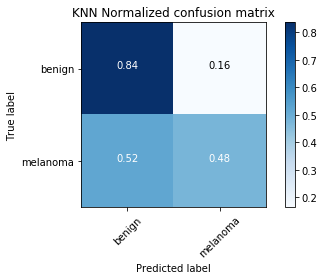

Classifier:  ETC
              precision    recall  f1-score   support

           0       0.72      0.84      0.77        61
           1       0.71      0.55      0.62        44

   micro avg       0.71      0.71      0.71       105
   macro avg       0.71      0.69      0.69       105
weighted avg       0.71      0.71      0.71       105

Normalized confusion matrix
[[0.83606557 0.16393443]
 [0.45454545 0.54545455]]


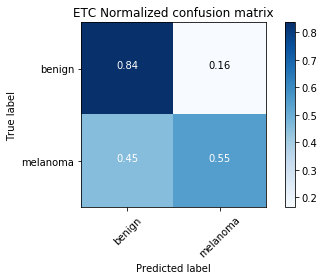

Classifier:  RFC
              precision    recall  f1-score   support

           0       0.73      0.80      0.77        61
           1       0.68      0.59      0.63        44

   micro avg       0.71      0.71      0.71       105
   macro avg       0.71      0.70      0.70       105
weighted avg       0.71      0.71      0.71       105

Normalized confusion matrix
[[0.80327869 0.19672131]
 [0.40909091 0.59090909]]


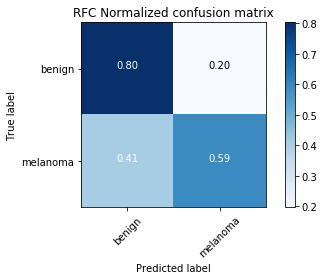

Classifier:  AdaBoost
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        61
           1       0.77      0.55      0.64        44

   micro avg       0.74      0.74      0.74       105
   macro avg       0.75      0.72      0.72       105
weighted avg       0.75      0.74      0.73       105

Normalized confusion matrix
[[0.8852459  0.1147541 ]
 [0.45454545 0.54545455]]


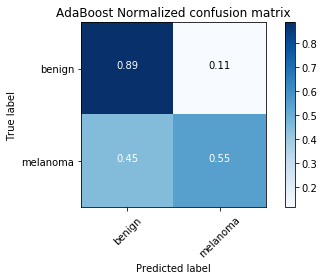

Classifier:  XGB
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        61
           1       0.68      0.57      0.62        44

   micro avg       0.70      0.70      0.70       105
   macro avg       0.70      0.69      0.69       105
weighted avg       0.70      0.70      0.70       105

Normalized confusion matrix
[[0.80327869 0.19672131]
 [0.43181818 0.56818182]]


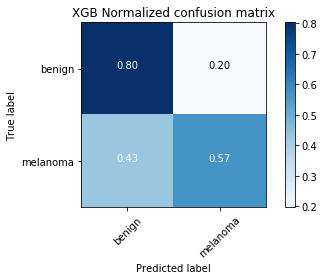

Classifier:  Ensemble
              precision    recall  f1-score   support

           0       0.75      0.87      0.80        61
           1       0.76      0.59      0.67        44

   micro avg       0.75      0.75      0.75       105
   macro avg       0.76      0.73      0.73       105
weighted avg       0.75      0.75      0.75       105

Normalized confusion matrix
[[0.86885246 0.13114754]
 [0.40909091 0.59090909]]


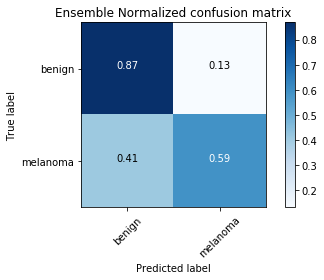

Classifier:  SVC_FS
              precision    recall  f1-score   support

           0       0.71      0.82      0.76        61
           1       0.69      0.55      0.61        44

   micro avg       0.70      0.70      0.70       105
   macro avg       0.70      0.68      0.69       105
weighted avg       0.70      0.70      0.70       105

Normalized confusion matrix
[[0.81967213 0.18032787]
 [0.45454545 0.54545455]]


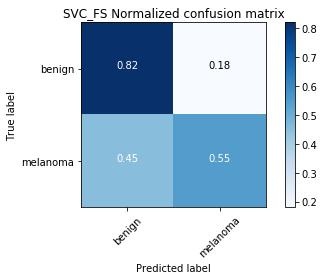

Classifier:  LR_FS
              precision    recall  f1-score   support

           0       0.73      0.80      0.77        61
           1       0.68      0.59      0.63        44

   micro avg       0.71      0.71      0.71       105
   macro avg       0.71      0.70      0.70       105
weighted avg       0.71      0.71      0.71       105

Normalized confusion matrix
[[0.80327869 0.19672131]
 [0.40909091 0.59090909]]


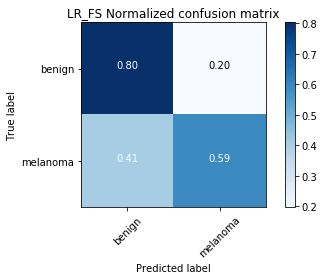

Classifier:  KNN_FS
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        61
           1       0.73      0.50      0.59        44

   micro avg       0.71      0.71      0.71       105
   macro avg       0.72      0.68      0.69       105
weighted avg       0.72      0.71      0.70       105

Normalized confusion matrix
[[0.86885246 0.13114754]
 [0.5        0.5       ]]


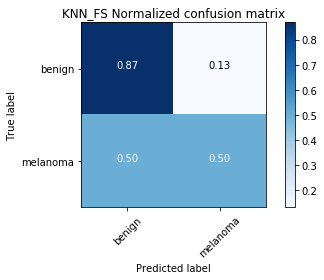

Classifier:  ETC_FS
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        61
           1       0.73      0.55      0.62        44

   micro avg       0.72      0.72      0.72       105
   macro avg       0.72      0.70      0.70       105
weighted avg       0.72      0.72      0.72       105

Normalized confusion matrix
[[0.85245902 0.14754098]
 [0.45454545 0.54545455]]


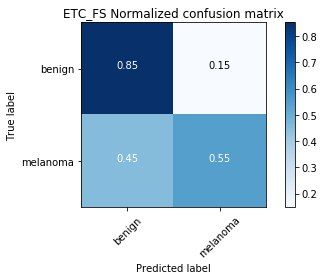

Classifier:  RFC_FS
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        61
           1       0.57      0.57      0.57        44

   micro avg       0.64      0.64      0.64       105
   macro avg       0.63      0.63      0.63       105
weighted avg       0.64      0.64      0.64       105

Normalized confusion matrix
[[0.68852459 0.31147541]
 [0.43181818 0.56818182]]


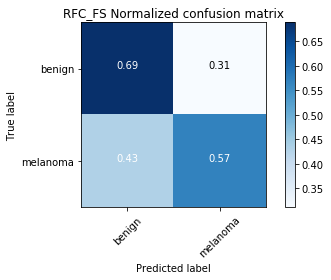

Classifier:  AdaBoost_FS
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        61
           1       0.63      0.50      0.56        44

   micro avg       0.67      0.67      0.67       105
   macro avg       0.66      0.64      0.64       105
weighted avg       0.66      0.67      0.66       105

Normalized confusion matrix
[[0.78688525 0.21311475]
 [0.5        0.5       ]]


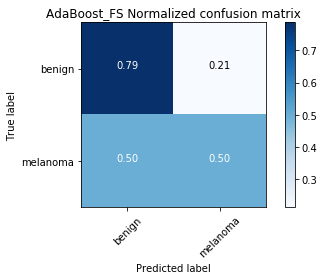

Classifier:  XGB_FS
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        61
           1       0.67      0.55      0.60        44

   micro avg       0.70      0.70      0.70       105
   macro avg       0.69      0.67      0.68       105
weighted avg       0.69      0.70      0.69       105

Normalized confusion matrix
[[0.80327869 0.19672131]
 [0.45454545 0.54545455]]


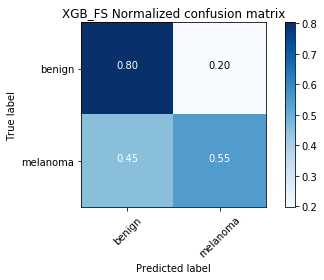

Classifier:  Ensemble_FS
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        61
           1       0.67      0.55      0.60        44

   micro avg       0.70      0.70      0.70       105
   macro avg       0.69      0.67      0.68       105
weighted avg       0.69      0.70      0.69       105

Normalized confusion matrix
[[0.80327869 0.19672131]
 [0.45454545 0.54545455]]


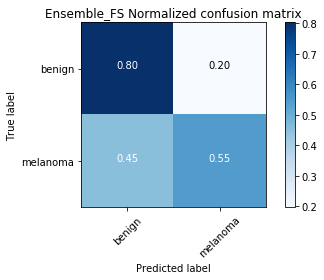

Classifier:  SVC_PCA
              precision    recall  f1-score   support

           0       0.69      0.72      0.70        61
           1       0.59      0.55      0.56        44

   micro avg       0.65      0.65      0.65       105
   macro avg       0.64      0.63      0.63       105
weighted avg       0.64      0.65      0.65       105

Normalized confusion matrix
[[0.72131148 0.27868852]
 [0.45454545 0.54545455]]


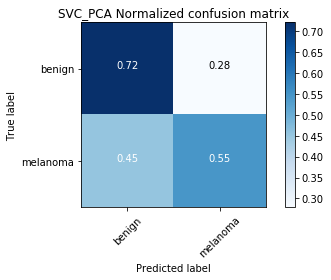

Classifier:  LR_PCA
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        61
           1       0.73      0.43      0.54        44

   micro avg       0.70      0.70      0.70       105
   macro avg       0.71      0.66      0.66       105
weighted avg       0.70      0.70      0.68       105

Normalized confusion matrix
[[0.8852459  0.1147541 ]
 [0.56818182 0.43181818]]


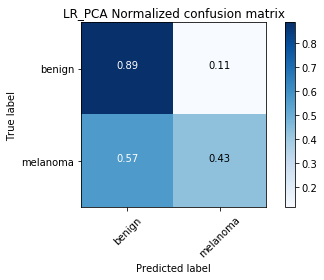

Classifier:  KNN_PCA
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        61
           1       0.69      0.45      0.55        44

   micro avg       0.69      0.69      0.69       105
   macro avg       0.69      0.65      0.65       105
weighted avg       0.69      0.69      0.67       105

Normalized confusion matrix
[[0.85245902 0.14754098]
 [0.54545455 0.45454545]]


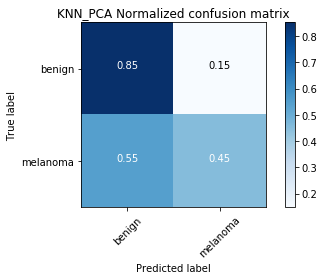

Classifier:  ETC_PCA
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        61
           1       0.73      0.55      0.62        44

   micro avg       0.72      0.72      0.72       105
   macro avg       0.72      0.70      0.70       105
weighted avg       0.72      0.72      0.72       105

Normalized confusion matrix
[[0.85245902 0.14754098]
 [0.45454545 0.54545455]]


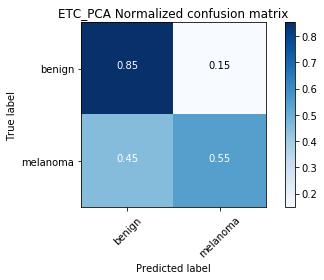

Classifier:  RFC_PCA
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        61
           1       0.72      0.59      0.65        44

   micro avg       0.73      0.73      0.73       105
   macro avg       0.73      0.71      0.72       105
weighted avg       0.73      0.73      0.73       105

Normalized confusion matrix
[[0.83606557 0.16393443]
 [0.40909091 0.59090909]]


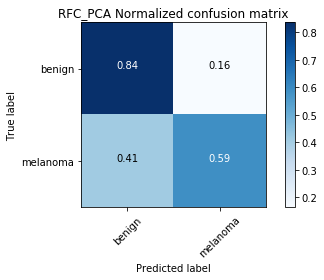

Classifier:  AdaBoost_PCA
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        61
           1       0.62      0.52      0.57        44

   micro avg       0.67      0.67      0.67       105
   macro avg       0.66      0.65      0.65       105
weighted avg       0.66      0.67      0.66       105

Normalized confusion matrix
[[0.7704918  0.2295082 ]
 [0.47727273 0.52272727]]


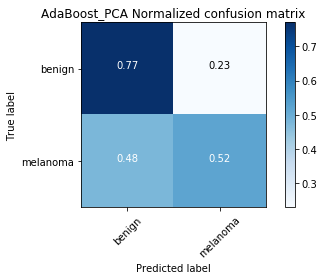

Classifier:  XGB_PCA
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        61
           1       0.60      0.59      0.60        44

   micro avg       0.67      0.67      0.67       105
   macro avg       0.66      0.66      0.66       105
weighted avg       0.67      0.67      0.67       105

Normalized confusion matrix
[[0.72131148 0.27868852]
 [0.40909091 0.59090909]]


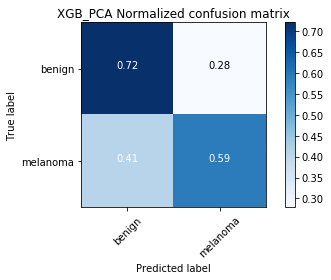

Classifier:  Ensemble_PCA
              precision    recall  f1-score   support

           0       0.70      0.75      0.72        61
           1       0.62      0.55      0.58        44

   micro avg       0.67      0.67      0.67       105
   macro avg       0.66      0.65      0.65       105
weighted avg       0.66      0.67      0.66       105

Normalized confusion matrix
[[0.75409836 0.24590164]
 [0.45454545 0.54545455]]


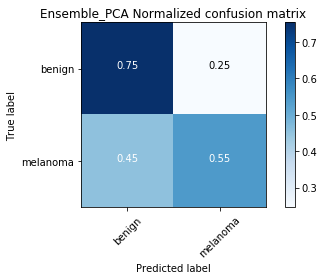

In [5]:
models = {'SVC':SVC_best, 'LR':LR_best,'KNN':KNN_best,
          'ETC':ETR_best,'RFC':RFC_best,'AdaBoost':AdaBoost_best,'XGB':XGB_best,'Ensemble':ensemble,
         'SVC_FS':SVC_FS, 'LR_FS':LR_FS,'KNN_FS':KNN_FS, 'ETC_FS':ETR_FS,'RFC_FS':RFC_FS, 'AdaBoost_FS':AdaBoost_FS,'XGB_FS':XGB_FS,'Ensemble_FS':ensemble_FS,
         'SVC_PCA':SVC_PCA, 'LR_PCA':LR_PCA,'KNN_PCA':KNN_PCA, 'ETC_PCA':ETR_PCA,'RFC_PCA':RFC_PCA,'AdaBoost_PCA':AdaBoost_PCA,'XGB_PCA':XGB_PCA,'Ensemble_PCA':ensemble_PCA,
         }
class_names = ["benign","melanoma"]

pca = PCA(n_components=0.95)
pca.fit(X_scale)
X_test_pca = pca.transform(X_test)

fs = SelectPercentile(f_classif, 10).fit(X_scale, Y)
X_test_fs = fs.transform(X_test)

for clf_name in models:
    clf = models[clf_name]
    #print(clf_name)
    if('PCA'in clf_name):
        y_pred = clf.predict(X_test_pca)
    elif('FS'in clf_name):
        y_pred = clf.predict(X_test_fs)
    else:
        y_pred = clf.predict(X_test)
    print("Classifier: ", clf_name)
    print(classification_report(y_test, y_pred))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='%s Normalized confusion matrix'%clf_name)
    plt.show()

## Make prediction

In [ ]:
X_scv = np.load('X_test_feature.npy')
#y_scv = ETR_best.predict(X_scv)
y_scv = ensemble.predict(X_scv)
y_scv

## Merge with CNN results

In [ ]:
df_CNN1 = pd.read_csv('data/InterceptionV3_modify.csv')
df_CNN2 = pd.read_csv('data/exemple_test_InceptionV3_original.csv')
df_CNN3 = pd.read_csv('data/InterceptionV3.csv')
Y1 = df_CNN1['Malignant'].values
Y2 = df_CNN2['Malignant'].values
Y3 = df_CNN3['Malignant'].values
y_res = (Y1+Y2+Y3+2*y_scv)/5
y_res[y_res<0.5]=0
y_res[y_res>=0.5]=1

y_csv = y_res

## Save prediction result

In [ ]:
df_submission = pd.read_csv('data/test.csv')
df_submission.loc[:, 'Malignant'] = y_csv
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/exemple_ensemble_with_CNN_only.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file